In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
from torchvision import transforms as T
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision import transforms
import numpy as np
import random

In [2]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = maskrcnn_resnet50_fpn(pretrained=False)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

# Number of categories and a background
num_classes = 1+16
model = get_model_instance_segmentation(num_classes)



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')  

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/MyDrive/TEETH/inference'

/content/gdrive/.shortcut-targets-by-id/1qXs_T41ECoC5i5YXJLKaXD2IbzLZHK0k/inference


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
ls

inference.ipynb  instance_seg_500_epoch.pt  top_001-200/  xyz.png


In [7]:
wts = torch.load('instance_seg_500_epoch.pt',map_location=device)
model.load_state_dict(wts)

<All keys matched successfully>

In [8]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [92]:
# open an image
img = Image.open('xyz.png')
# image=np.array(img)
trans = transforms.ToTensor()
inp=trans(img)
inp = inp.unsqueeze(0) # add pad 
inp=inp.to(device)
with torch.no_grad():
  prediction = model(inp)

In [31]:
def get_random_color():
    return (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))

In [38]:
def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4
    Returns:
        contours, hierarchy
    """
    ver = cv2.__version__
    if ver.startswith('4') or ver.startswith('2'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif ver.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 2, 3 or 4 to call this method')

    return contours, hierarchy

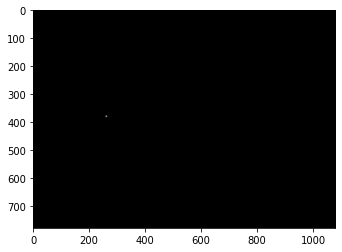

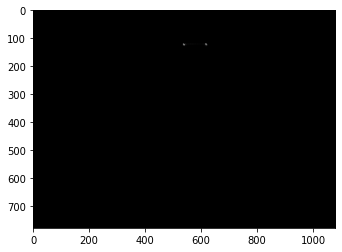

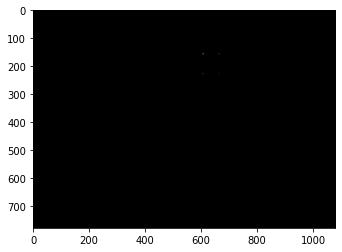

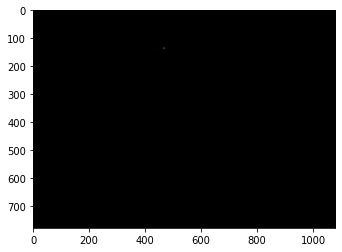

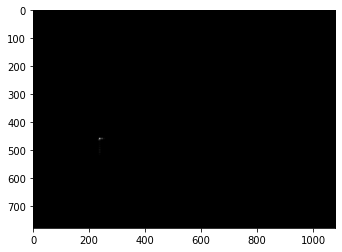

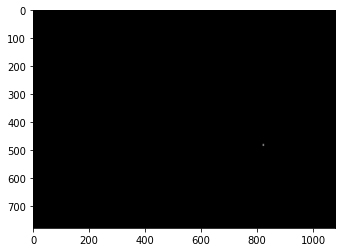

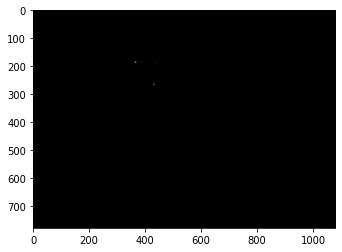

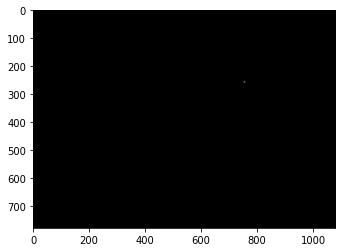

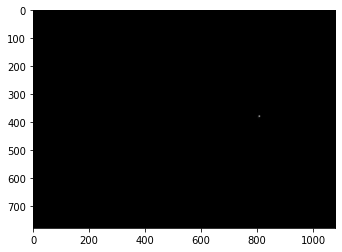

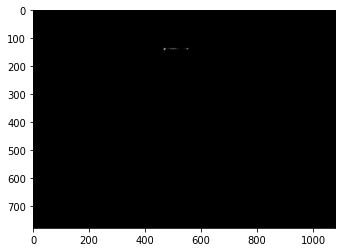

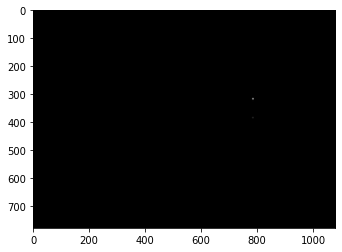

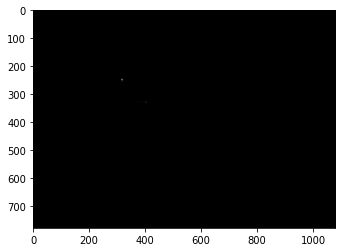

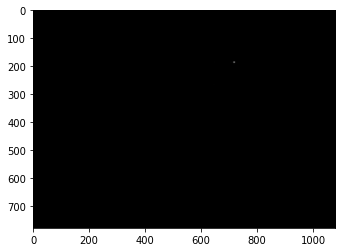

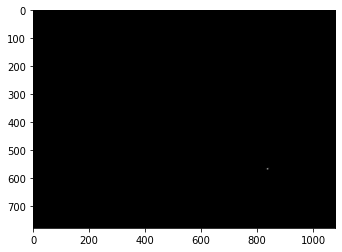

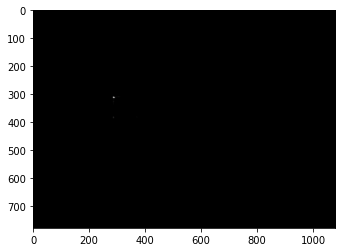

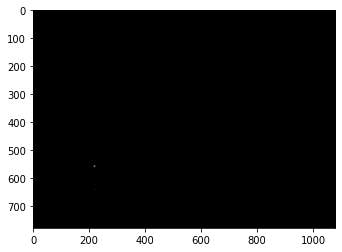

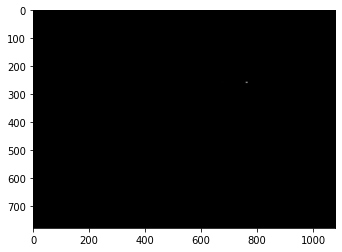

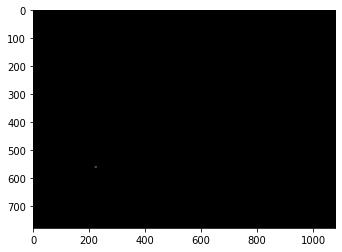

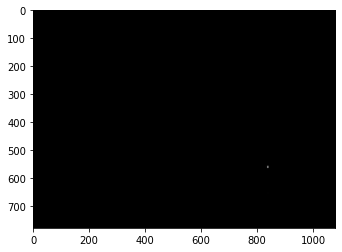

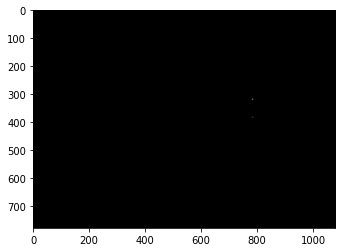

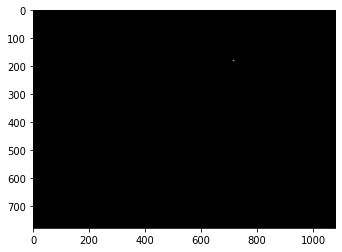

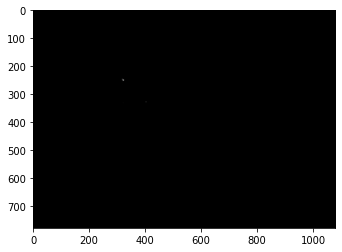

In [114]:
import matplotlib.pyplot as plt
nooflb=len(prediction[0]['labels'])
# out=prediction
y_pred_final=prediction[0]['masks']
pred1 = y_pred_final.cpu().detach().numpy()
# print(pred1.shape)
x = np.moveaxis(pred1, 1,0 )
# print('squeeze',x.shape)
# x[0].shape
for i in range(0,nooflb):
  plt.imshow(x[0,i],cmap='gray')
  plt.show()

In [115]:
x.shape

(1, 22, 777, 1080)

In [120]:
print(x.shape)
pred2 = np.argmax(x, axis = 0)
print(pred2.shape)

(1, 22, 777, 1080)
(22, 777, 1080)


In [10]:
len(prediction[0]['labels']),prediction[0]['labels']

(22,
 tensor([ 3,  9, 10,  7,  2, 15,  6, 12, 14,  8, 13,  5, 11, 16,  4,  1, 11,  2,
         15, 12, 10,  6]))

In [11]:
im = prediction[0]['masks']
labels = prediction[0]['labels']
labels = [t.item() for t in labels]
# labels.sort()
print(im.shape)
for i in range(len(labels)):
    out = im[i,0]
    out[out>0]=1
    if labels[i] not in [5,6,7,8,9,10,11,12]:
        continue
    print(labels[i])
    plt.figure(figsize=(15,10))
    # plt.imshow(image.permute(1,2,0))
    plt.imshow(img)
    plt.imshow(out,cmap='jet', alpha=0.2)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
pred=prediction

In [13]:
# instances = COCO('top_001-200/coco_annotation_linux_topfolder.json')

In [14]:
pred_score = list(pred[0]['scores'].detach().to('cpu').numpy())
pred_t = [pred_score.index(x) for x in pred_score if x>0.5][-1]    
masks = (pred[0]['masks']>0.5).squeeze().detach().to('cpu').numpy()
masks = masks[:pred_t+1]

In [21]:
img1 = cv2.imread('xyz.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

In [22]:
for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img2 = cv2.addWeighted(img1, 1, rgb_mask, 0.5, 0)
    plt.figure(figsize=(20,30))
    plt.imshow(img2)
    plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-03d0b8cafb8f>", line 2, in <module>
    rgb_mask = random_colour_masks(masks[i])
NameError: name 'random_colour_masks' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-pa

NameError: ignored

In [23]:
out=prediction
import cv2

In [24]:
y_pred_final=out[0]['masks']
pred1 = y_pred_final.cpu().detach().numpy()
pred2 = np.argmax(pred1[0], axis = 0)
# filename = output_file_name + '.jpg'
# cv2.imwrite(filename, pred*255)

In [25]:
# plt.imshow(pred2,cmap='gray')
# plt.show()

In [26]:
pred1[5].shape

(1, 777, 1080)

In [27]:
for i in range(0,len(pred1)):
  plt.imshow(pred1[i][0][:,:,i],cmap='gray')
  plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-4868db28e765>", line 2, in <module>
    plt.imshow(pred1[i][0][:,:,i],cmap='gray')
IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File 

IndexError: ignored